# Recherche d'un modèle optimal

Nous allons dans ce notebook décrire les différentes étapes de la séléction, de l'entrainement et de l'optimisation d'un modèle. Nous avons initiallement retenu un certain nombre de features suite à la phase d'analyse exploratoire des données.

In [7]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("/Users/cyrillemaire/Documents/Yotta/Project/FINAL_TEST/productsubscription_dc_cl_js")
# Attention, veuillez modifier le sys.path si vous souhaitez exécuter ce notebook.

### Chargement des scripts, du projet et de la config:

In [8]:
import yaml
import numpy as np

from subscription_forecast.domain import model_evaluation
from subscription_forecast.domain.model_evaluation import ModelEvaluator
from subscription_forecast.domain import feature_engineering
from subscription_forecast.infrastructure import preprocessing

In [9]:
config_path ="../config/config.yml"

In [10]:
with open(config_path, 'r') as file_in:
    CONFIG = yaml.safe_load(file_in)

In [11]:
TARGET = CONFIG['filters']['TARGET']
features_to_drop = CONFIG['filters']['features_to_drop']

## Choix des critères d'évaluation

Premièrement, il nous fallait décider de critères pour évaluer la performance de notre modèle. Il nous a paru important de faire attention au nombre de <b> vrais positifs </b> et de <b> faux négatifs </b>, en d'autres termes: combien d'acheteurs potentiels ont été identifiés par le modèle, et combien ont été raté. Il semble plus important de ne pas rater d'acheteurs, plutôt que d'appeler trop de clients.


Pour cela, nous avons décider de nous intéresser à la <b> précision </b> et au <b> recall </b>. En particulier, nous nous intéresserons à la courbe precision/recall. Pour comparer la performance de nos modèles, nous comparerons les valeurs de l'aire sous la courbe precision/recall (<b> Precision/Recall AUC </b>).

## Choix d'un algorithme d'apprentissage

Nous voulions avant tout avoir un modèle de classification facilement explicable. Nous sommes donc partis sur 2 types d'algorithmes:     <br>
- La Régression Logistique
- Le Random Forest

A chaque étape du feature engineering, nous avons comparé la régression logistique et le random forest. Pour chaque configuration, les performances du random forest étaient bien meilleures. 

### Regression logistique après feature engineering:

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#### Préprocessing des datas:

In [13]:
client_full = preprocessing.features_from(CONFIG['training_data']['data_path'],
                                          CONFIG['training_data']['client_file_name'],
                                          CONFIG['training_data']['socio_eco_file_name'],
                                          features_to_drop)

#### Préparation du train set et du test pour évaluer le modèle:

In [15]:
y = client_full[TARGET]
y = y.replace({'Yes': 1, 'No': 0})
x = client_full.drop(columns=TARGET)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

#### Fit du pipeline de régression logistique:

In [16]:
MODEL_NAME = 'lr'

final_pipeline = Pipeline(steps=[
        ('transformer', feature_engineering.transformer),
        (MODEL_NAME, LogisticRegression())])

final_pipeline.fit(x_train, y_train);

#### Evaluation des performances du modèle obtenu:

Model train accuracy :  0.894
Model accuracy :  0.893
Model precision :  0.624
Model recall =  0.206
Confusion Matrix : 
 [[ 216  835]
 [ 130 7847]]
AUC precision recall curve is :  0.431


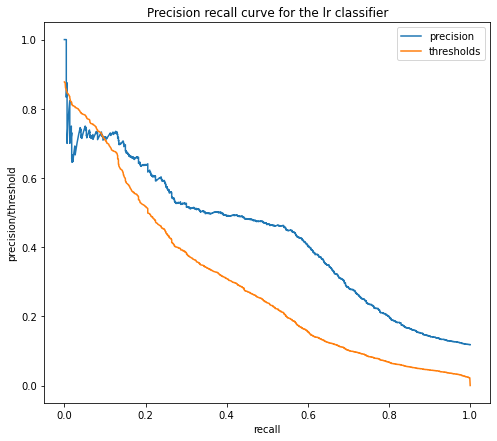

In [17]:
evaluator = ModelEvaluator(MODEL_NAME, final_pipeline)

evaluator.print_metrics(x_test, y_test, x_train, y_train)
evaluator.plot_precision_recall(x_test, y_test, x_train, y_train)

Nous obtenons ici 2 choses importantes: <br>
- Les métriques de performance du modèle avec le seuil (threshold) naturel de 0.5
- La courbe de precision/recall liée à la variation du seuil
<br>

Nous reparleront plus tard de l'importance de toutes ces métriques, étudions maintenant le Random Forest.

### Résultats avec le Random Forest:

In [18]:
MODEL_NAME = 'rf'

final_pipeline = Pipeline(steps=[
        ('transformer', feature_engineering.transformer),
        (MODEL_NAME, RandomForestClassifier(random_state=12, n_estimators=100, max_depth=5))])

final_pipeline.fit(x_train, y_train);

#### Evaluation des performances du Random Forest:

Model train accuracy :  0.896
Model accuracy :  0.895
Model precision :  0.711
Model recall =  0.167
Confusion Matrix : 
 [[ 175  876]
 [  71 7906]]
AUC precision recall curve is :  0.444


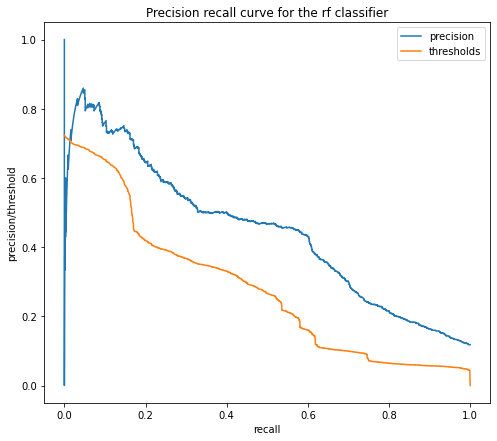

In [19]:
evaluator = ModelEvaluator(MODEL_NAME, final_pipeline)

evaluator.print_metrics(x_test, y_test, x_train, y_train)
evaluator.plot_precision_recall(x_test, y_test, x_train, y_train)

Avec des hyper-paramètres non optimisés, nous observons que le Random Forest a une meilleure aire sous la courbe (AUC) que la régression logistique, ce qui nous interesse particulièrement. Il a également une précision plus élevée, mais un recall légèrement plus faible. <br> 

A première vue et sans optimisation, le Random Forest semble plus performant. De plus, en observant les courbes, on voit que dans les 2 cas, il y a un "coude" à partir duquel la courbe diminue fortement. Ce "coude" apparait pour des valeurs plus élevées pour le Random Forest. Cela signifie qu'en diminuant le seuil (courbe en orange), le rapport entre la precision et le recall sera plus intéressant pour le Random Forest. <br>

L'algorithme préférable semble être le Random Forest.

## Choix des features

La phase d'EDA nous a permis de pré-sélectionner les features à ne pas garder pour l'optimisation. <br>
De plus, nous n'utiliserons pas job_type. Cette variable semble relativement corrélée à la cible, mais malgrè nos efforts nous n'avons pas réussi à augmenter les performances du modèle en l'ajoutant.

In [20]:
print("features non utilisées:")
CONFIG['filters']['features_to_drop']

features non utilisées:


['contact',
 'duration_contact',
 'nb_contact_last_campaign',
 'has_default',
 'job_type']

De nombreuses combinaisons de features et de feature engineering ont été testées sur base de l'augmentation des performance des algorithmes. De plus, l'affichage de l'importance des features (pour le RF) ou des coefficients (pour le RL) nous a permis d'évaluer leur impact.

#### Exemple pour le Random Forest:

In [21]:
evaluator.get_feature_importance()

Feature importance: 
 [0.27  0.026 0.096 0.013 0.007 0.001 0.002 0.001 0.002 0.003 0.    0.205
 0.072 0.212 0.041 0.048]


Dans l'ordre, les features retenues sont:
- Result_last_campaign: 1 si succes, 0 pour toues les autre cas
- Age: Nan imputé à la mediane, Robust scaler
- Date: les mois on été extraits de la date puis target encodés
- Balance et Nb_contact : Robust Scaler
- Education et Status: One hot encoder
- Socio_eco features: Robust Scaler
- housing_loan and perso_loan : encodé, 2 si les 2 loans sont true, 1 pour 1 loan, 0 sinon
- day_last_contact: transformation 1/x


L'utilisation de ces features nous a permis d'améliorer la performance pour les 2 algorithmes.

## Valeurs manquantes:


Il est possible d'améliorer la prédiction en ne gardant que les observations avec moins de 3 valeurs manquantes après le préprocessing:

In [22]:
client_full, rows_removed = preprocessing.drop_nan(client_full)

Before preprocessing the dataset contains 41274 missing values
After preprocessing the dataset contains 38355 missing values


Afin d'avoir un modèle plus fonctionnel, nous avons néanmoins décidé de ne pas filtrer les valeurs manquantes afin d'être capable d'effectuer des prédictions sur n'importe quel client.

## Optimisation des hyperparamètres:

Enfin, nous avons utilisé le module d'optimisation bayesienne Optuna pour finir d'améliorer notre modèle. Pour cela, nous avons testé 3 études d'optimisation, chacune cherchant à maximiser une métrique différente: <br>
- Average Precision
- Recall
- F1 score <br>

Nous avons essayé d'optimiser la Régression Logistique ainsi que le Random Forest. Ce dernier s'est une fois de plus retrouvé plus performant après optimisation.

Les résultats les plus satisfaisants sont obtenus avec l'optimisation de l'"average precision". Cela reste cohérent avec notre objectif d'obtenir la meilleur courbe precision/recall.


In [23]:
 optimal_parameters = {'rf_n_estimators': 668,
                          'rf_max_depth': 10,
                          'rf_min_samples_leaf': 10,
                          'rf_min_samples_split': 31,
                          'rf_bootstrap': True,
                          'rf_max_features': 'auto'}

## Modèle optimisé:

In [24]:
optimal_pipeline = Pipeline(steps=[('transformer', feature_engineering.transformer),
                                 (MODEL_NAME, RandomForestClassifier(random_state=12,
                                            max_depth=optimal_parameters['rf_max_depth'],
                                            n_estimators=optimal_parameters['rf_n_estimators'],
                                            min_samples_leaf=optimal_parameters['rf_min_samples_leaf'],
                                            min_samples_split=optimal_parameters['rf_min_samples_split'],
                                            bootstrap=optimal_parameters['rf_bootstrap'],
                                            max_features=optimal_parameters['rf_max_features']))])

optimal_pipeline.fit(x_train, y_train);

Model train accuracy :  0.901
Model accuracy :  0.896
Model precision :  0.679
Model recall =  0.206
Confusion Matrix : 
 [[ 216  835]
 [ 102 7875]]
AUC precision recall curve is :  0.456


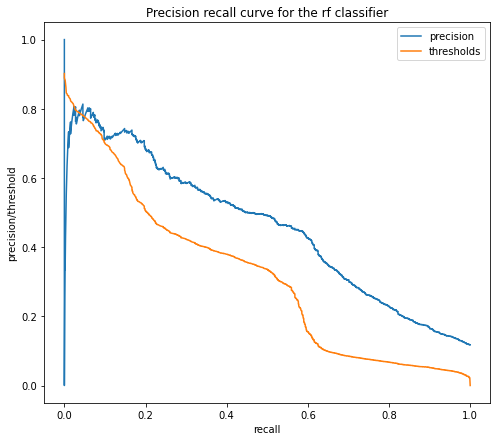

In [25]:
opt_evaluator = ModelEvaluator(MODEL_NAME, optimal_pipeline)

opt_evaluator.print_metrics(x_test, y_test, x_train, y_train)
opt_evaluator.plot_precision_recall(x_test, y_test, x_train, y_train)

Bien que la précision diminue légèrement, l'aire sous la courbe ainsi que le recall augmentent. De plus, la courbe descend "moins vite" quand le seuil diminue, ce qui est très intéressant.

### Choix du seuil:

In [26]:
from sklearn.metrics import recall_score,\
    precision_score, \
    confusion_matrix, \
    accuracy_score

Avec le seuil par défaut de 0.5, la précision est de 0.68 et le recall de 0.192. On observe néanmoins sur la courbe qu'on peut augmenter grandement le recall sans trop perdre en précision en ramenant le seuil vers 0.2

In [27]:
THRESHOLD = 0.2

In [28]:
engineered_data = final_pipeline.steps[0][1].transform(x_test)
predictions_proba = final_pipeline.steps[1][1].predict_proba(engineered_data)

In [29]:
predictions = np.where(predictions_proba[:, 1] >= THRESHOLD, 1, 0)

In [30]:
print("Model accuracy : ", np.around(accuracy_score(y_test, predictions), decimals=3))
print("Model precision : ", np.around(precision_score(y_test, predictions, average="binary", pos_label=1), decimals=3))
print("Model recall = ", np.around(recall_score(y_test, predictions, average="binary", pos_label=1), decimals=3))
print("Confusion Matrix : \n", confusion_matrix(y_test, predictions, labels=[1, 0]))

Model accuracy :  0.869
Model precision :  0.452
Model recall =  0.568
Confusion Matrix : 
 [[ 597  454]
 [ 725 7252]]


Avec un seuil de 0.2, on obtient une précision de 0.452 pour un recall de 0.568. Intéressons nous à la matrice de confusion :
En terme de clients appelés, cela signifie que: <br>
- Sur un total de 1051 clients qui ont souscrit, 597 ont été appelés (contre 216 avec le seuil de 0.5), 454 n'ont pas été appelés.
- 725 client qui ne souscrivent pas n'ont pas été appelés.
- 7252 clients qui ne souscrivent pas n'ont pas été appelés. <br>
 